In [2]:
!pip install prophet

In [10]:
!pip install prophet pandas matplotlib seaborn scikit-learn

In [11]:
from google.colab import files
uploaded = files.upload()

Saving Walmart_Sales.csv to Walmart_Sales.csv


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv575ay9z/_9g0xa9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv575ay9z/rt1ywuv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37257', 'data', 'file=/tmp/tmpv575ay9z/_9g0xa9q.json', 'init=/tmp/tmpv575ay9z/rt1ywuv1.json', 'output', 'file=/tmp/tmpv575ay9z/prophet_model7ilhuiaa/prophet_model-20250517170814.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:08:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


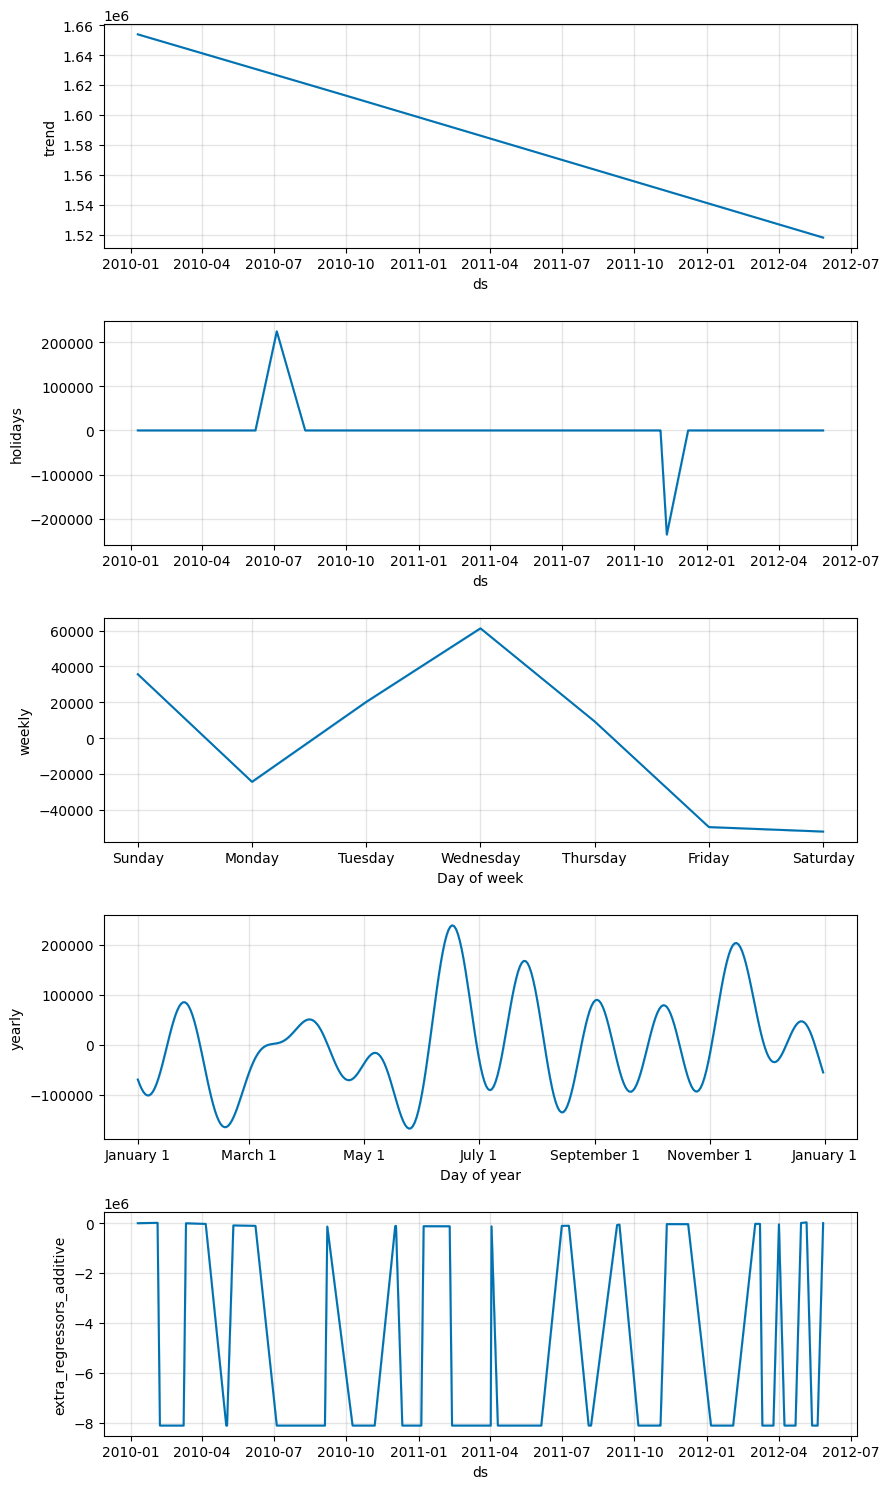

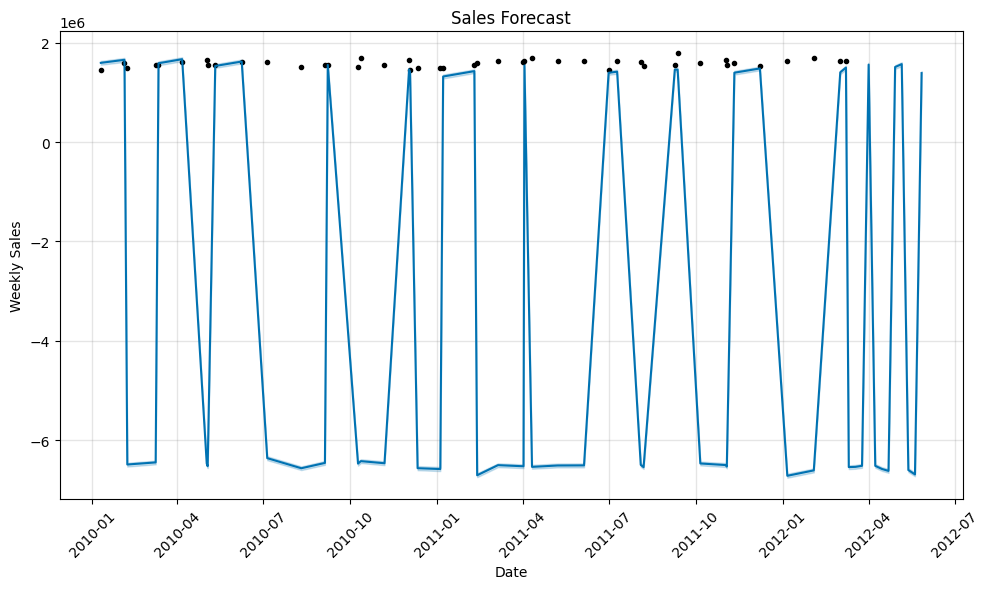

MAE: 5562633.52
RMSE: 6719652.18


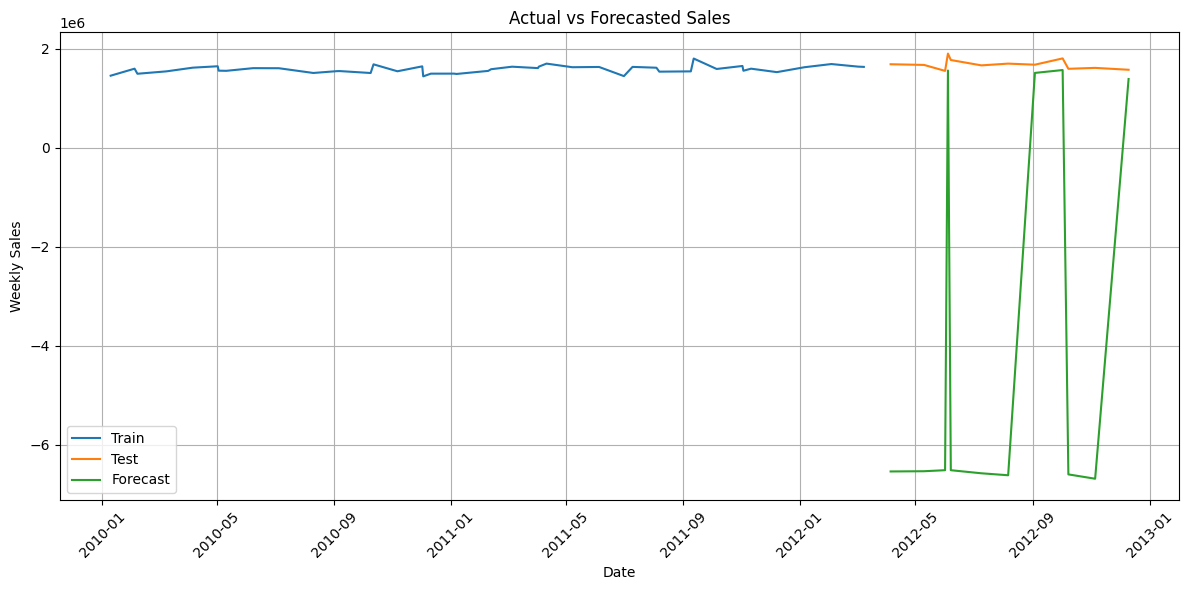

In [16]:
# Step 3: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 4: Define Column Names Manually
columns = [
    "Store", "Date", "Weekly_Sales", "Holiday_Flag",
    "Temperature", "Fuel_Price", "CPI", "Unemployment"
]

# Step 5: Read CSV Line-by-Line and Clean It
with open("/content/Walmart_Sales.csv", "r") as f:
    lines = f.readlines()

data = []
for i, line in enumerate(lines):
    if i == 0:  # Skip header row
        continue
    parts = line.strip().split(",")
    if len(parts) == len(columns):
        data.append(parts)

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Step 6: Convert Data Types Safely
df['Store'] = df['Store'].astype(int)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Weekly_Sales'] = pd.to_numeric(df['Weekly_Sales'], errors='coerce')
df['Holiday_Flag'] = df['Holiday_Flag'].astype(int)
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
df['Fuel_Price'] = pd.to_numeric(df['Fuel_Price'], errors='coerce')
df['CPI'] = pd.to_numeric(df['CPI'], errors='coerce')
df['Unemployment'] = pd.to_numeric(df['Unemployment'], errors='coerce')

# Drop rows with missing or invalid values
df.dropna(subset=['Store', 'Date', 'Weekly_Sales'], inplace=True)

# Sort by Date
df.sort_values('Date', inplace=True)

# Step 7: Select One Store for Forecasting
store_id = 1
df_store = df[df['Store'] == store_id].copy()

# Step 8: Prepare for Prophet
df_prophet = df_store[['Date', 'Weekly_Sales', 'Holiday_Flag']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
df_prophet['on_holiday'] = df_prophet['Holiday_Flag'].values

# Optional regressors
df_prophet['temperature'] = df_store['Temperature'].values
df_prophet['fuel_price'] = df_store['Fuel_Price'].values
df_prophet['cpi'] = df_store['CPI'].values
df_prophet['unemployment'] = df_store['Unemployment'].values

# Step 9: Train/Test Split
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet[:train_size]
test_df = df_prophet[train_size:]

# Step 10: Build Prophet Model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.add_country_holidays(country_name='US')
model.add_regressor('on_holiday')
model.add_regressor('temperature')
model.add_regressor('fuel_price')
model.add_regressor('cpi')
model.add_regressor('unemployment')

model.fit(train_df[['ds', 'y', 'on_holiday', 'temperature', 'fuel_price', 'cpi', 'unemployment']])

# Step 11: Make Forecast
future = model.make_future_dataframe(periods=len(test_df), freq='W')
for col in ['on_holiday', 'temperature', 'fuel_price', 'cpi', 'unemployment']:
    future[col] = df_prophet[col].reindex_like(future).fillna(0)

forecast = model.predict(future)

# Step 12: Plot Forecast
fig = model.plot_components(forecast)
plt.show()
fig = model.plot(forecast)
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 13: Evaluate Performance
preds = forecast.iloc[-len(test_df):]['yhat'].values
actual = test_df['y'].values

mae = mean_absolute_error(actual, preds)
rmse = np.sqrt(mean_squared_error(actual, preds))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Step 14: Plot Actual vs Forecasted Sales
plt.figure(figsize=(12,6))
plt.plot(train_df['ds'], train_df['y'], label='Train')
plt.plot(test_df['ds'], test_df['y'], label='Test')
plt.plot(test_df['ds'], preds, label='Forecast')
plt.legend()
plt.title("Actual vs Forecasted Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()